# becoming a backprop ninja


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
# context length: how many characters do we take to predict the next one?
import random
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# boilerplate done

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {
          str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * \
    (5/3)/((n_embd * block_size)**0.5)
# using b1 just for fun, it's useless because of BN
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
# note: Bessel's correction (dividing by n-1, not n)
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
# if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
# Yb is the indices of the correct answer. It is going through every row and getting the correct answer index (probability), and getting the mean
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,  # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3374, grad_fn=<NegBackward0>)

In [ ]:
# [[1,2], [1,2], [1,2]] = [[3], [3], [3]]

In [39]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

# How to do this: go backwards up and calculate dX for every variable used in reverse order
# NOTE: If I want to calculate dX, i'm actually looking at the line below X to see what it is
# That makes sense right because that's what actually happening to X
# # Forward pass
# x = 2
# y = x * 3    # y uses x
# z = y + 1    # z uses y

# # Backward pass
# dz = 1       # Starting gradient
# dy = dz * 1  # Look at how y was used in z's equation
# dx = dy * 3  # Look at how x was used in y's equation

# AT EVERY NODE: dL/dSelf = dOut/dSelf * dL/dOut (local derivative * derivative of output)

# loss = -logprobs[range(n), Yb].mean():
# in `loss = -logprobs[range(n), Yb].mean()` we are doing: loss = -(a+b+c)/3 = -1/3a + -1/3b + -1/3c
# the rest are zeros bc not part of the loss, only the Yb plucked out affect it: by dL/dx - 1/n for x in (a,b,c)
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n

# logprobs = probs.log():
dprobs = (1.0 / probs) * dlogprobs

# probs = counts * counts_sum_inv:
# ATTENTION: Broadcasting happening bc counts and counts_sum_inv have shape [32,27] and [32,1]
# `(counts * dprobs)` is the multiplication, `.sum()` is the replication
# a[3x3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1      # Same b1 is reused across cols
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3

# Micrograd: if thing is used multiple times, must sum

# Each element in counts_sum_inv was "copied" 27 times during broadcasting
# This is a general rule: when backpropagating through broadcasted operations, you need to sum across the broadcasted dimensions to get the correct gradient.
# rule: if the variable is broadcasted, need this
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

# probs = counts * counts_sum_inv
dcounts = (counts_sum_inv) * dprobs

# counts_sum_inv = counts_sum**-1
dcounts_sum = (-1 * counts_sum ** -2) * dcounts_sum_inv

# Looking at `counts_sum = counts.sum(1, keepdims=True)`: counts [32,7] and counts_sum [32,1]
# Let counts = a, count_sum = b. Then how do the b's depend on a's? That is local derivative.
# a11 a12 a13  --->   b1 (= a11 + a12 + a13)   -- b1 only depends on the 1st row, b2 on 2nd, etc.
# a21 a22 a23  --->   b2 (= a21 + a22 + a23)
# a31 a32 a33  --->   b3 (= a31 + a32 + a33)
dcounts += torch.ones_like(counts) * dcounts_sum

# counts = norm_logits.exp()
dnorm_logits = counts * dcounts

# norm_logits = logits - logit_maxes: [32,27] - [32,1]
# c11 c12 c13 = a11 a12 a13     b1
# c21 c22 c23 = a21 a22 a23  -  b2
# c31 c32 c33 = a31 a32 a33     b3

# so c32 = a32 - b3
# - means that the c's flow to each of the a's but also to the b's but b's are broadcast so need sum
dlogits = dnorm_logits.clone()  # flow
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# logit_maxes = logits.max(1, keepdim=True).values
# pluck out the maxes
dlogits += F.one_hot(logits.max(1).indices,
                     num_classes=logits.shape[1]) * dlogit_maxes

# onwards just watched
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [40]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.337357759475708 diff: 2.384185791015625e-07


In [42]:
# backward pass (derive by doing math and simplifying the operation of the softmax)

# convert logits into probs w/ each row summing to 1 (this is model's current preds)
dlogits = F.softmax(logits, 1)

# gradient says "decrease probability for wrong predictions, increase for right ones"
# - If model predicted 0.7 for correct class, gradient is -0.3 (0.7 - 1)
# - If model predicted 0.3 for wrong class, gradient is 0.3 (0.3 - 0)
dlogits[range(n), Yb] -= 1
dlogits /= n

# I can only get approximate to be true, my maxdiff is 6e-9
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


**Think about what we want the model to do:**

For CORRECT predictions (where Yb points):

- If model says 0.7 probability (too low, should be 1.0)
- Gradient = 0.7 - 1 = -0.3
- Negative gradient means "increase this logit"
- Because when we update weights with `-learning_rate * gradient`, it becomes a positive change

For WRONG predictions:

- If model says 0.3 probability (too high, should be 0.0)
- Gradient = 0.3 - 0 = 0.3
- Positive gradient means "decrease this logit"
- Because when we update weights with -learning_rate \* gradient, it becomes a negative change
- So subtracting 1 from the true class creates exactly the push/pull we want:

So subtracting 1 from the true class creates exactly the push/pull we want:
**Pull UP** probabilities for correct answers (negative gradient)
**Push DOWN** probabilities for wrong answers (positive gradient)
The subtraction is what gives us this opposite behavior for correct vs incorrect predictions.


In [43]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [44]:
F.softmax(logits, 1)[0]
# Look at prob distribution of the first sample

tensor([0.0684, 0.0845, 0.0188, 0.0499, 0.0189, 0.0830, 0.0230, 0.0349, 0.0179,
        0.0319, 0.0352, 0.0362, 0.0373, 0.0287, 0.0365, 0.0148, 0.0087, 0.0198,
        0.0165, 0.0567, 0.0527, 0.0217, 0.0239, 0.0685, 0.0615, 0.0274, 0.0227],
       grad_fn=<SelectBackward0>)

In [45]:
dlogits[0] * n
# Rescale the gradient back to original magnitude before it was averaged over the batch size
# See how the one correct sample is negative

tensor([ 0.0684,  0.0845,  0.0188,  0.0499,  0.0189,  0.0830,  0.0230,  0.0349,
        -0.9821,  0.0319,  0.0352,  0.0362,  0.0373,  0.0287,  0.0365,  0.0148,
         0.0087,  0.0198,  0.0165,  0.0567,  0.0527,  0.0217,  0.0239,  0.0685,
         0.0615,  0.0274,  0.0227], grad_fn=<MulBackward0>)

In [46]:
dlogits[0].sum()  # this sums to zero

tensor(2.0955e-09, grad_fn=<SumBackward0>)

The amount of push and pull is exactly equalized because they sum to zero. Why do they sum to 0? Because we just took the softmax of the logits which normally makes them sum to 1 because they are probabilities. But instead we just subtracted 1 from the correct index.

**The amount that your solution is incorrect is the exact amount your logits will be pushed and pulled:** For instance if it perfectly predicted output, then the `dlogits` would be all 0s and the gradient would effectuate no change.

### This is the magic of cross entropy loss


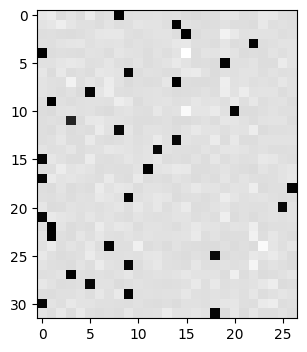

In [47]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [56]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / \
    torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(0.0062, grad_fn=<MaxBackward1>)


In [59]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * \
    (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size  # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * \
            (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad  # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
        #     break

12297
      0/ 200000: 3.8012
  10000/ 200000: 2.2046
  20000/ 200000: 2.3818
  30000/ 200000: 2.4745
  40000/ 200000: 1.9834
  50000/ 200000: 2.3524
  60000/ 200000: 2.4452
  70000/ 200000: 2.0964
  80000/ 200000: 2.3501
  90000/ 200000: 2.1230
 100000/ 200000: 2.0386
 110000/ 200000: 2.3359
 120000/ 200000: 2.0256
 130000/ 200000: 2.3642
 140000/ 200000: 2.3013
 150000/ 200000: 2.2053
 160000/ 200000: 1.9383
 170000/ 200000: 1.8414
 180000/ 200000: 2.0360
 190000/ 200000: 1.9603


In [60]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [61]:
# evaluate train and val loss

@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.071840763092041
val 2.1087331771850586


In [62]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        # concat into (N, block_size * n_embd)
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ W2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amori.
kif.
jari.
reetlanna.
sane.
mahubefaresynci.
aqui.
ner.
kia.
chaiiv.
kaleigh.
ham.
joce.
quint.
salin.
alianni.
waythoniearisia.
kaellinsley.
dae.
